# COMP5318 Assignment 1

To test the model, please go to end of the page

## Import Package

In [1]:
import h5py
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
print(os.listdir("./Input/train"))
print(os.listdir("./Input/test"))

['images_training.h5', 'labels_training.h5']
['images_testing.h5', 'labels_testing_2000.h5']


## Computer Status

In [2]:
from cpuinfo import get_cpu_info
import platform
import wmi

computer = wmi.WMI()
os_info = computer.Win32_OperatingSystem()[0]
proc_info = computer.Win32_Processor()[0]
gpu_info = computer.Win32_VideoController()[0]
system_ram = float(os_info.TotalVisibleMemorySize) / 1048576  

print('Operating Systems: {0}'.format(platform.platform()))
print('Central Processing Unit: {0}'.format(proc_info.Name))
print('Number of Processors: {0}'.format(get_cpu_info()['count']))

Operating Systems: Windows-10-10.0.19041-SP0
Central Processing Unit: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
Number of Processors: 8


## Load Data

Load Training Set

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


Load testing set

In [5]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test_original = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

Shape the test set size to match test label size.

In [8]:
data_test = data_test_original[:2000]
data_exam = data_test_original[2000:]
print(data_test.shape,label_test.shape,data_exam.shape)

(2000, 784) (2000,) (3000, 784)


## Data preprocessing

### Classes count

In [9]:
dat_train = pd.DataFrame(data_train)
dat_test = pd.DataFrame(label_train)

In [13]:
df = dat_train.merge(dat_test, how='inner',left_index=True, right_index=True)
df.rename(columns={'0_x':'0'},inplace=True)
df.rename(columns={'0_y':'label'},inplace=True)

In [11]:
count = df.groupby(['label']).count()
count = pd.DataFrame(count['0'])
count.rename(columns={'0':'counts'},inplace=True)
count['ratio'] = count / sum(count['counts'])
count

,counts,ratio
label,,
0,3041,0.101367
1,2972,0.099067
2,2936,0.097867
3,3008,0.100267
4,2954,0.098467
5,3029,0.100967
6,3023,0.100767
7,3013,0.100433
8,3040,0.101333


<BarContainer object of 10 artists>

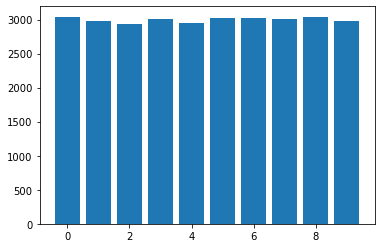

In [12]:
plt.bar(count.index, count['counts'])

### Normalise Data

Min Max Scaler

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(data_train)

data_train_mm = scaler1.transform(data_train)
data_test_mm = scaler1.transform(data_test)

Standard (Z-value) Scaler

In [14]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(data_train)

data_train_sd = scaler2.transform(data_train)
data_test_sd = scaler2.transform(data_test)

### PCA - Data Reshaping

Visualise Cumulative explained_variance_ratio

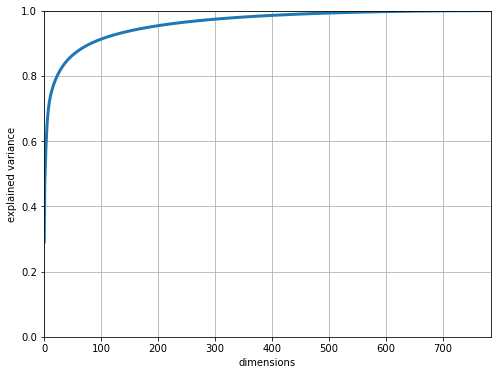

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (8,6))
plt.plot(cumsum, linewidth=3)

plt.axis([0, data_train.shape[1], 0, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

Finding best number of components

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

accuracy_list = []
run_time = []
for i in range(30, 220, 5):
    pca = PCA(n_components = i)
    pca.fit(data_train_mm)
    data_train_pca = pca.transform(data_train_mm)
    data_test_pca = pca.transform(data_test_mm)
    
    t1 = time.time()
    lin_svm = SVC()
    lin_svm.fit(data_train_pca, label_train)
    t2 = time.time()
    
    svm_pred = lin_svm.predict(data_test_pca)
    accuracy_list.append(accuracy_score(label_test, svm_pred))
    run_time.append(round(t2-t1))

In [17]:
print(accuracy_list)
print(run_time)

[0.855, 0.8625, 0.864, 0.8635, 0.863, 0.8655, 0.864, 0.8655, 0.865, 0.8645, 0.8665, 0.8695, 0.869, 0.8705, 0.869, 0.8705, 0.869, 0.869, 0.872, 0.8705, 0.871, 0.873, 0.873, 0.8705, 0.8705, 0.8715, 0.8705, 0.87, 0.8715, 0.8695, 0.872, 0.8725, 0.8725, 0.8705, 0.872, 0.8725, 0.872, 0.8715]
[8, 8, 8, 10, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 15, 14, 14, 14, 15, 16, 19, 18, 18, 19, 20, 23, 24, 23, 24, 23, 23, 26, 25, 27, 29, 29, 29]


Calculate components with 95% accumulated explained variance.

In [18]:
pca=PCA(n_components=0.95)
X_train_re = pca.fit_transform(data_train)
X_test_re = pca.transform(data_test)
print("Reduced shape of training data: {}".format(str(X_train_re.shape)))
print("Reduced shape of testing data: {}".format(str(X_test_re.shape)))

Reduced shape of training data: (30000, 188)
Reduced shape of testing data: (2000, 188)


Located Elbow at 135 Components for Min_Max Scaler

In [61]:
pca=PCA(n_components=135)
X_train_remm = pca.fit_transform(data_train_mm)
X_test_remm = pca.transform(data_test_mm)
print("Reduced shape of training data: {}".format(str(X_train_remm.shape)))
print("Reduced shape of testing data: {}".format(str(X_test_remm.shape)))

Reduced shape of training data: (30000, 135)
Reduced shape of testing data: (2000, 135)


Located Elbow at 135 Components for Standard Scaler

In [62]:
X_train_resd = pca.fit_transform(data_train_sd)
X_test_resd = pca.transform(data_test_sd)
print("Reduced shape of training data: {}".format(str(X_train_resd.shape)))
print("Reduced shape of testing data: {}".format(str(X_test_resd.shape)))

Reduced shape of training data: (30000, 135)
Reduced shape of testing data: (2000, 135)


## Implement Classifiers

### KNN

Use GridSearchCV function to do Parameter Tuning, and set StratifiedKFold as 10 fold.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier(n_jobs=-1)

n_neighbors = [3, 5, 8]
weights = ['uniform', 'distance']
p = [1,2]
grid = dict(n_neighbors=n_neighbors,weights=weights,p=p)
cv = StratifiedKFold(n_splits=10)
t1 = time.time()
grid_knn = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_knn_result = grid_knn.fit(X_train_remm, label_train)
t2 = time.time()
t_knn3 = t2-t1

print("Best: %f using %s" % (grid_knn_result.best_score_, grid_knn_result.best_params_))
print(t_knn3)

Best: 0.860267 using {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
589.4324462413788


In [22]:
cv_results_knn = grid_knn_result.cv_results_
cv_results_knn

{'mean_fit_time': array([0.07500722, 0.11944144, 0.28414795, 0.13143163, 0.31176333,
        0.25373006, 0.29810433, 0.23248019, 0.31433516, 0.18088663,
        0.17961278, 0.17305913]),
 'std_fit_time': array([0.0027517 , 0.04200827, 0.18879409, 0.09114265, 0.17444113,
        0.20401412, 0.21289338, 0.25661221, 0.19162684, 0.16063413,
        0.08893058, 0.1078172 ]),
 'mean_score_time': array([114.03512106,  85.44983902,  52.70891478,  25.40301998,
        122.91481867,  40.57836363,  21.0957454 ,  42.93931534,
         93.89172995,  56.57026289,  29.02909198,   7.3511126 ]),
 'std_score_time': array([ 4.95152229, 30.55955259, 48.12330173, 13.11268974, 55.08954549,
        16.82725796, 11.27662361, 27.04110814, 53.04828942, 34.51144196,
         6.34300285,  1.77208699]),
 'param_n_neighbors': masked_array(data=[3, 3, 3, 3, 5, 5, 5, 5, 8, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fil

Generate Classification Report - training set

In [23]:
from sklearn.metrics import classification_report
grid_knn_pred1 = grid_knn.predict(X_train_remm)
print(classification_report(label_train, grid_knn_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3041
           1       1.00      1.00      1.00      2972
           2       1.00      1.00      1.00      2936
           3       1.00      1.00      1.00      3008
           4       1.00      1.00      1.00      2954
           5       1.00      1.00      1.00      3029
           6       1.00      1.00      1.00      3023
           7       1.00      1.00      1.00      3013
           8       1.00      1.00      1.00      3040
           9       1.00      1.00      1.00      2984

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



Generate Classification Report - testing set

In [24]:
grid_knn_pred2 = grid_knn.predict(X_test_remm)
print(classification_report(label_test, grid_knn_pred2))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       192
           1       0.99      0.99      0.99       184
           2       0.74      0.73      0.74       206
           3       0.86      0.82      0.84       207
           4       0.73      0.72      0.73       220
           5       0.99      0.85      0.92       190
           6       0.59      0.62      0.61       190
           7       0.86      0.94      0.90       192
           8       0.96      0.94      0.95       227
           9       0.89      0.94      0.92       192

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



Generate Confusion Matrix - training set

In [25]:
from sklearn.metrics import confusion_matrix
cm_knn1 = confusion_matrix(label_train, grid_knn_pred1)

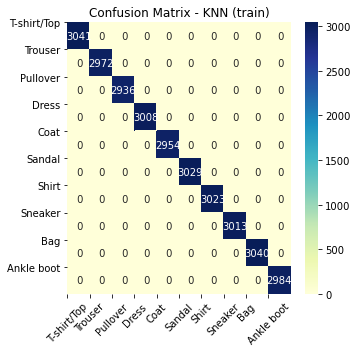

In [69]:
classes_list = ["T-shirt/Top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

plt.figure(figsize=(5,5))
sns.heatmap(cm_knn1, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - KNN (train)")
plt.show()

Generate Confusion Matrix - testing set

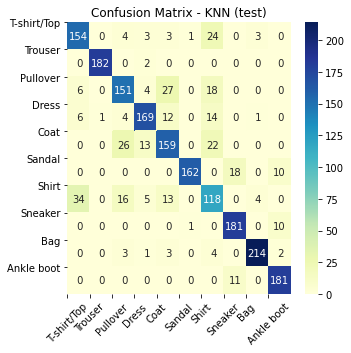

In [67]:
cm_knn2 = confusion_matrix(label_test, grid_knn_pred2)

plt.figure(figsize=(5,5))
sns.heatmap(cm_knn2, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - KNN (test)")
plt.show()

### Decision Tree

Use GridSearchCV function to do Parameter Tuning, and set StratifiedKFold as 10 fold.

In [70]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

max_depth = [5, 10, 15]
criterion = ['entropy', 'gini']

grid = dict(max_depth=max_depth,criterion=criterion)
cv = StratifiedKFold(n_splits=10)
t1 = time.time()
grid_dt = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_dt_result = grid_dt.fit(X_train_remm, label_train)
t2 = time.time()
t_dt3 = t2-t1

print("Best: %f using %s" % (grid_dt_result.best_score_, grid_dt_result.best_params_))
print(t_dt3)

Best: 0.770867 using {'criterion': 'entropy', 'max_depth': 10}
64.24933099746704


In [71]:
cv_results_dt = grid_dt_result.cv_results_
cv_results_dt

{'mean_fit_time': array([10.24764755, 15.85658908, 17.44451301,  2.80002036,  5.12152376,
         6.16414952]),
 'std_fit_time': array([0.23225281, 0.33319376, 0.34271971, 0.0312965 , 0.08456573,
        0.27435846]),
 'mean_score_time': array([0.00169535, 0.0016844 , 0.0018949 , 0.00149615, 0.00189526,
        0.00138705]),
 'std_score_time': array([0.00045713, 0.00065137, 0.00029912, 0.0004986 , 0.00029924,
        0.00047921]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'gini', 'gini',
                    'gini'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 10, 15, 5, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'entropy', 'max_depth': 5},
  {'criterion': 'entropy', 'max_depth': 10},
  {'criterion': 'entropy', 'max_depth': 15},
  {'criteri

Generate Classification Report - training set

In [42]:
grid_dt_pred1 = grid_dt.predict(X_train_remm)
print(classification_report(label_train, grid_dt_pred1))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3041
           1       0.97      0.97      0.97      2972
           2       0.73      0.70      0.71      2936
           3       0.87      0.89      0.88      3008
           4       0.66      0.78      0.72      2954
           5       0.95      0.86      0.90      3029
           6       0.65      0.56      0.60      3023
           7       0.86      0.95      0.90      3013
           8       0.95      0.92      0.93      3040
           9       0.97      0.95      0.96      2984

    accuracy                           0.84     30000
   macro avg       0.84      0.84      0.84     30000
weighted avg       0.84      0.84      0.84     30000



Generate Classification Report - testing set

In [43]:
grid_dt_pred2 = grid_dt.predict(X_test_remm)
print(classification_report(label_test, grid_dt_pred2))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       192
           1       0.93      0.95      0.94       184
           2       0.70      0.67      0.68       206
           3       0.75      0.74      0.75       207
           4       0.66      0.74      0.70       220
           5       0.88      0.81      0.84       190
           6       0.47      0.46      0.46       190
           7       0.80      0.89      0.84       192
           8       0.93      0.88      0.90       227
           9       0.92      0.90      0.91       192

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



Generate Confusion Matrix - training set

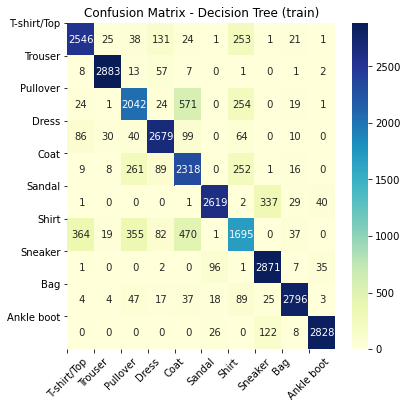

In [72]:
cm_dt1 = confusion_matrix(label_train, grid_dt_pred1)

plt.figure(figsize=(6,6))
sns.heatmap(cm_dt1, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - Decision Tree (train)")
plt.show()

Generate Confusion Matrix - testing set

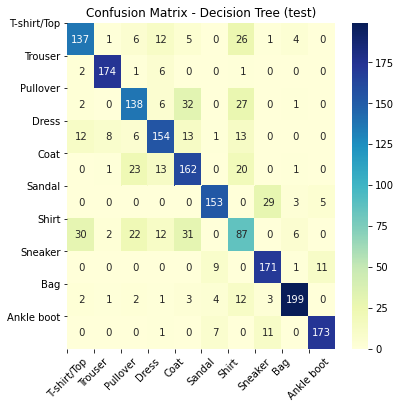

In [73]:
cm_dt2 = confusion_matrix(label_test, grid_dt_pred2)

plt.figure(figsize=(6,6))
sns.heatmap(cm_dt2, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - Decision Tree (test)")
plt.show()

### Suupport Vector Machine

In [74]:
from sklearn.svm import SVC
model = SVC()

C = [0.1, 10, 100]
kernel = ['poly', 'rbf', 'sigmoid']
grid = dict(C=C,kernel=kernel)
cv = StratifiedKFold(n_splits=10)
t1 = time.time()
grid_svm = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_svm_result = grid_svm.fit(X_train_remm, label_train)
t2 = time.time()
t_svm3 = t2-t1

print("Best: %f using %s" % (grid_svm_result.best_score_, grid_svm_result.best_params_))
print(t_svm3)

Best: 0.899733 using {'C': 10, 'kernel': 'rbf'}
1299.909915447235


In [75]:
cv_results_svm = grid_svm_result.cv_results_
cv_results_svm

{'mean_fit_time': array([270.07710745, 199.83211403, 198.12058525, 118.294959  ,
        100.13307502,  94.95433204, 121.26166294, 107.25858197,
         75.45264261]),
 'std_fit_time': array([ 4.29650122,  3.54135543,  3.98151226,  4.81471864,  3.71931457,
         2.90265002,  2.97806846,  4.07990008, 13.19988402]),
 'mean_score_time': array([33.85982285, 39.23550415, 29.53883502, 18.71973443, 23.89690747,
        21.73576779, 18.23320222, 24.3829896 , 11.86576226]),
 'std_score_time': array([0.86746253, 1.02860197, 1.81797282, 1.44293206, 0.8372007 ,
        1.06080321, 0.55761104, 0.60015322, 3.59443251]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 10, 10, 10, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['poly', 'rbf', 'sigmoid', 'poly', 'rbf', 'sigmoid',
                    'poly', 'rbf', 'sigmoid'],
              mas

Generate Classification Report - training set

In [76]:
grid_svm_pred1 = grid_svm.predict(X_train_remm)
print(classification_report(label_train, grid_svm_pred1))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3041
           1       1.00      0.99      1.00      2972
           2       0.95      0.95      0.95      2936
           3       0.96      0.97      0.97      3008
           4       0.94      0.94      0.94      2954
           5       1.00      0.99      0.99      3029
           6       0.94      0.90      0.92      3023
           7       0.98      0.99      0.98      3013
           8       1.00      1.00      1.00      3040
           9       0.99      0.98      0.99      2984

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



Generate Classification Report - testing set

In [77]:
grid_svm_pred2 = grid_svm.predict(X_test_remm)
print(classification_report(label_test, grid_svm_pred2))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       192
           1       0.99      0.99      0.99       184
           2       0.81      0.82      0.82       206
           3       0.85      0.86      0.86       207
           4       0.85      0.82      0.83       220
           5       0.98      0.97      0.98       190
           6       0.71      0.69      0.70       190
           7       0.93      0.95      0.94       192
           8       0.97      0.97      0.97       227
           9       0.96      0.96      0.96       192

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



Generate Confusion Matrix - training set

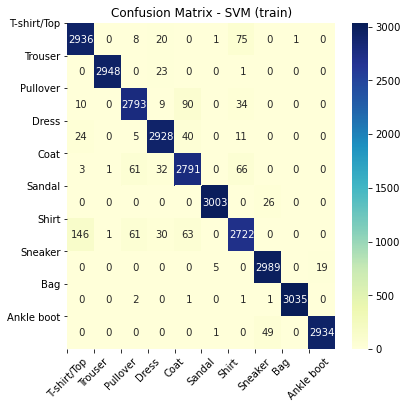

In [79]:
cm_svm1 = confusion_matrix(label_train, grid_svm_pred1)

plt.figure(figsize=(6,6))
sns.heatmap(cm_svm1, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - SVM (train)")
plt.show()

Generate Confusion Matrix - testing set

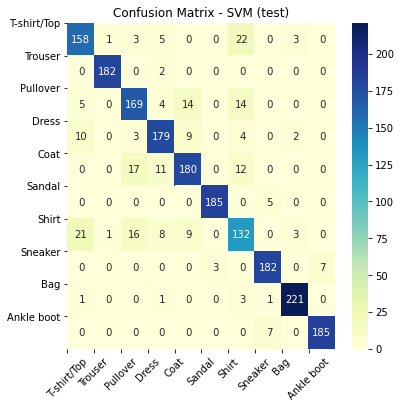

In [80]:
cm_svm2 = confusion_matrix(label_test, grid_svm_pred2)

plt.figure(figsize=(6,6))
sns.heatmap(cm_svm2, annot=True,fmt="2g",cmap="YlGnBu")
plt.xticks(np.arange(len(classes_list)), classes_list,rotation = 45)
plt.yticks(np.arange(len(classes_list)), classes_list,rotation = 0)
plt.title("Confusion Matrix - SVM (test)")
plt.show()

## Best Classifier Evaluation - SVM

Below cell is to predict 3000 unlabeled test data.

In [13]:
import time
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Load data
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test_original = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
data_test = data_test_original[:2000]
data_exam = data_test_original[2000:]

#Start counting running time
t1 = time.time()

#Pre-process data - scaling
scale = MinMaxScaler()
scale.fit(data_train)
train_mm = scale.transform(data_train)
exam_mm = scale.transform(data_exam)

#Pre-process data - reshaping
pca=PCA(n_components=135)
train_remm = pca.fit_transform(train_mm)
exam_remm = pca.transform(exam_mm)

#Set best parameter
svm = SVC(C=10, kernel='rbf')

#Fitting the model and prediction
svm.fit(train_remm, label_train)
svm_pred = svm.predict(exam_remm)

#Finish counting running time
t2 = time.time()

#Expport prediction
output = svm_pred

with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)

#Print out running time of the model
print('The running time of svm is:', round((t2-t1),2),'seconds')

The running time of svm is: 34.07 seconds
